In [1]:
### Important ###
### Run this cell if you are using Google Colab

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
print('[Done] openjdk8 has been installed')

!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz -C /usr/lib/
!rm spark-2.4.5-bin-hadoop2.7.tgz
print('[Done] Spark has been installed')

!pip install -q findspark
print('[Done] findspark has been installed')

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/lib/spark-2.4.5-bin-hadoop2.7"
print('[Done] Environment variables has been set')

import findspark
findspark.init()
print('[Done] You can use pyspark now.')

[Done] openjdk8 has been installed
[Done] Spark has been installed
[Done] findspark has been installed
[Done] Environment variables has been set
[Done] You can use pyspark now.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
# 1. LOAD DATA

In [0]:
df_train = spark.read.option("inferSchema", "true").csv("BearTraining.csv", header=True)

In [0]:
df_test = spark.read.option("inferSchema", "true").csv("BearTesting.csv", header=True)

In [6]:
df_test.show()

+------+-----------+------------------+-----------+---------+------+-------+
|Weight|Front Claws|Pupillary Distance| Hair Color|Ear Shape|Length|Grizzly|
+------+-----------+------------------+-----------+---------+------+-------+
|   225|        3.7|              11.3|      Blond|  Rounded|   6.7|     No|
|   489|        7.8|              12.0|      Black|  Rounded|  11.7|    Yes|
|   451|        5.1|              11.1|      White|    Broad|  11.8|    Yes|
|   234|        9.1|              11.8| Dark Brown|  Pointed|   8.8|     No|
|   233|        4.6|              12.4|Light Brown|    Broad|   6.7|     No|
|   477|        2.9|              10.4|      Blond|    Broad|   7.3|     No|
|   235|        4.9|              11.3|   Cinnamon|    Broad|   5.5|     No|
|   320|        3.1|              10.7| Dark Brown|    Broad|  10.0|     No|
|   442|        1.7|               9.4|      Blond|  Rounded|   9.2|    Yes|
|   349|        1.5|              10.4|      Blond|  Pointed|   9.5|     No|

In [7]:
df_train.show()

+------+-----------+------------------+-----------+---------+------+
|Weight|Front Claws|Pupillary Distance| Hair Color|Ear Shape|Length|
+------+-----------+------------------+-----------+---------+------+
|   399|        9.0|              12.0| Dark Brown|  Rounded|   9.6|
|   210|        9.6|              10.7|      Black|    Broad|   5.2|
|   488|        1.4|              15.1|      Blond|    Broad|   5.0|
|   451|        5.4|              12.3|      Black|    Broad|   8.9|
|   372|        3.5|               9.0|      White|  Pointed|   7.9|
|   488|        2.6|               9.7|      White|  Pointed|  10.6|
|   273|        7.9|              16.3|       null|    Broad|   9.4|
|   227|        4.6|              12.7|      White|    Broad|   9.5|
|   321|        5.0|               9.2|      White|    Broad|   9.9|
|   392|        3.8|              15.7|      Black|  Rounded|   9.2|
|   278|        5.5|              11.5|      Blond|    Broad|   6.1|
|   380|        5.4|              

In [0]:
# 2. SELECT FEATURES

In [0]:
df_train = df_train.select("Front Claws", "Pupillary Distance", "Ear Shape")
df_test = df_test.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")

In [0]:
# 3. DATA PREPROCESSING

In [0]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [0]:
# 4. TRANSFORM DATA

In [0]:
# df_train = df_train.withColumn("Hair Color",  when(df_train["Hair Color"] == "White", 0).
#                                               when(df_train["Hair Color"] == "Blond", 1).
#                                               when(df_train["Hair Color"] == "Light Brown", 2).
#                                               when(df_train["Hair Color"] == "Cinnamon", 3).
#                                               when(df_train["Hair Color"] == "Dark Brown", 4).
#                                               when(df_train["Hair Color"] == "Black", 5).
#                                               otherwise(6))

df_train = df_train.withColumn("Ear Shape", when(df_train["Ear Shape"] == "Pointed", 0).
                                            when(df_train["Ear Shape"] == "Broad", 1).
                                            when(df_train["Ear Shape"] == "Rounded", 2))

In [0]:
cols = df_train.columns
df_train = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_train)

In [0]:
# df_test = df_test.withColumn("Hair Color",  when(df_test["Hair Color"] == "White", 0).
#                                             when(df_test["Hair Color"] == "Blond", 1).
#                                             when(df_test["Hair Color"] == "Light Brown", 2).
#                                             when(df_test["Hair Color"] == "Cinnamon", 3).
#                                             when(df_test["Hair Color"] == "Dark Brown", 4).
#                                             when(df_test["Hair Color"] == "Black", 5).
#                                             otherwise(6))

df_test = df_test.withColumn("Ear Shape", when(df_test["Ear Shape"] == "Pointed", 0).
                                          when(df_test["Ear Shape"] == "Broad", 1).
                                          when(df_test["Ear Shape"] == "Rounded", 2))
df_test = df_test.withColumn("Grizzly", when(df_test["Grizzly"] == "No", 0).
                                        when(df_test["Grizzly"] == "Yes", 1))

In [0]:
cols = df_test.columns
cols.remove("Grizzly")
df_test = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_test)

In [0]:
# 5. NORMALIZATION

In [0]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
df_train = scaler.fit(df_train).transform(df_train)

In [0]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
df_test = scaler.fit(df_test).transform(df_test)

In [0]:
# 6. GENERATE MODEL

In [0]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)

In [0]:
# 7. VISUALIZATION

In [0]:
predictions = model.transform(df_test)

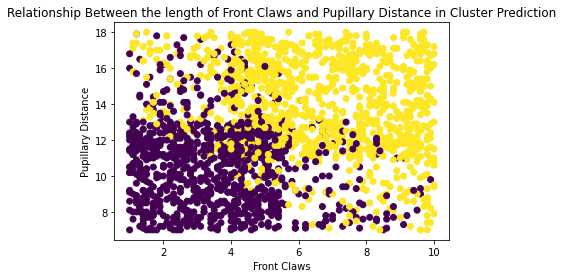

In [20]:
#VISUALIZATION
predictions = predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Front Claws"], predictions["Pupillary Distance"], c=predictions["prediction"])
ax.set_title('Relationship Between the length of Front Claws and Pupillary Distance in Cluster Prediction')
ax.set_xlabel('Front Claws')
ax.set_ylabel('Pupillary Distance')
plt.show()

In [0]:
# 8. MODEL TESTING AND EVALUATION

In [21]:
c = 0
for index, row in predictions.iterrows():
    if row["Grizzly"] == row["prediction"]:
        c = c + 1

print("Accuracy: {}%".format(c / len(predictions) * 100))

Accuracy: 83.55%
